In [2]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from seqeval.metrics import classification_report, precision_score
from IPython.display import HTML

from model import CNN_BiLSTM_CRF
from dataset import io2df, io2bio, padding, NERDataset
from utils import Config, load_ner_config
from visualisation import plot_classification_report, highlight_entities
from typing import List, Dict

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
config = Config('config.yaml')
config.__dict__

{'TR_PATH': 'data/supervised/train.txt',
 'VA_PATH': 'data/supervised/dev.txt',
 'TE_PATH': 'data/supervised/test.txt',
 'MAX_SEQ_LEN': 64,
 'MAX_WORD_LEN': 16,
 'BATCH_SIZE': 128,
 'LR': 0.001,
 'REG_LAMBDA': 0.0001,
 'MAX_GRAD_NORM': 100,
 'NUM_EPOCHS': 10,
 'WORD_EMBED_SIZE': 128,
 'CHAR_EMBED_SIZE': 128,
 'KERNEL_SIZE': 3,
 'LSTM_HIDDEN_SIZE': 128,
 'DROPOUT': 0.5}

In [4]:
te_titles = io2df(config.TE_PATH)

In [5]:
te_titles

,id,words,tags_fine_grained,tags_coarse_grained
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,..."
...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]"
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]"
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ..."


# Prepare data

In [6]:
TAG2IDX = load_ner_config('ner_tags/ner_fine_grained.json')
IDX2TAG = {i: t for t, i in TAG2IDX.items()}

WORD2IDX = load_ner_config('tokenizers/word2idx.json')
IDX2WORD = {i: t for t, i in WORD2IDX.items()}

CHAR2IDX = load_ner_config('tokenizers/char2idx.json')

In [7]:
# tag -> tagID
te_titles['tag_ids'] = te_titles['tags_fine_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])

# word -> wordID
te_titles['word_ids'] = te_titles['words'].transform(lambda x: [WORD2IDX[token] if token in WORD2IDX else WORD2IDX['UKN'] for token in x])

# padding
te_titles['word_ids'] = te_titles['word_ids'].transform(padding, max_len=config.MAX_SEQ_LEN)
te_titles['tag_ids'] = te_titles['tag_ids'].transform(padding, max_len=config.MAX_SEQ_LEN)

In [8]:
te_titles

,id,words,tags_fine_grained,tags_coarse_grained,tag_ids,word_ids
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 1, 1, 10, ...","[25, 2, 166, 2825, 2, 277, 246, 8, 2, 7432, 39..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca...","[1, 1, 1, 1, 1, 1, 1, 27, 27, 27, 1, 1, 1, 1, ...","[12, 288, 81, 5, 1541, 567, 267, 30529, 782, 1..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O...","[1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 1, 1, 1, 1, 1...","[198, 528, 2, 81, 1, 3, 1, 7, 22858, 267, 8, 2..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ...","[1, 63, 1, 1, 1, 55, 55, 55, 1, 1, 1, 1, 0, 0,...","[12, 15859, 1689, 3, 1122, 3247, 3210, 1, 3, 7..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,...","[1, 33, 33, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0...","[12, 15069, 675, 178, 6, 445, 50, 2480, 5, 359..."
...,...,...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[12, 1448, 453, 30, 9933, 7, 1423, 4, 0, 0, 0,..."
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]","[1, 55, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2162, 1, 278, 7, 2376, 4, 0, 0, 0, 0, 0, 0, 0..."
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth...","[1, 1, 42, 1, 42, 1, 1, 1, 1, 44, 44, 1, 44, 4...","[191, 95, 1, 3, 28054, 38, 47, 818, 20, 1, 163..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ...","[1, 33, 33, 33, 1, 22, 1, 1, 1, 1, 1, 1, 1, 1,...","[12, 4050, 1, 222, 7, 2443, 40, 1282, 2, 4180,..."


# Data loader

In [9]:
te_dataset = NERDataset(data=te_titles, idx2word=IDX2WORD, char2idx=CHAR2IDX, max_word_len=config.MAX_WORD_LEN)
te_dataloader = DataLoader(dataset=te_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

te_dataset.__getitem__(123)

100%|██████████| 37648/37648 [00:09<00:00, 3953.43it/s]


{'word_ids': tensor([ 3474,    48,    96,   115,   158,     3,    29,  1209,     9,  3190,
             5,   557,     7, 17140,     6,  2211,    34,     8,     2,   324,
          1231,   313,     3, 23582,     1,     3,    16,     2,   284,     5,
             9,  1597,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'char_ids': tensor([[28, 10,  7,  ...,  0,  0,  0],
         [ 3, 16,  4,  ...,  0,  0,  0],
         [48,  7,  8,  ...,  0,  0,  0],
         ...,
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0]]),
 'tag_ids': tensor([ 1,  1, 16, 16, 16,  1,  1,  1,  1,  1,  1,  1,  1, 22,  1,  1,  1,  1,
          1,  1,  1,  1,  1, 38, 38,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
          0,  0,  0,  0,  0,

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = CNN_BiLSTM_CRF(
    word_embed_size  = config.WORD_EMBED_SIZE,
    char_embed_size  = config.CHAR_EMBED_SIZE,
    kernel_size      = config.KERNEL_SIZE,
    max_word_len     = config.MAX_WORD_LEN,
    lstm_hidden_size = config.LSTM_HIDDEN_SIZE,
    dropout          = config.DROPOUT,
    word_voc_size    = len(WORD2IDX),
    char_voc_size    = len(CHAR2IDX),
    tag_voc_size     = len(TAG2IDX),
).to(device)
print(model)

word_embedding.weight                    initialized w with Xavier            parameters #: 4442240
char_embedding.char_embedding.weight     initialized w with Xavier            parameters #: 15488
char_embedding.char_conv1d.weight        initialized w with Xavier            parameters #: 49152
char_embedding.char_conv1d.bias          initialized b with zero              parameters #: 128
char_embedding.fc.weight                 initialized w with Xavier            parameters #: 262144
char_embedding.fc.bias                   initialized b with zero              parameters #: 128
lstm.weight_ih_l0                        initialized w with Xavier            parameters #: 65536
lstm.weight_hh_l0                        initialized w with Xavier            parameters #: 16384
lstm.weight_ih_l0_reverse                initialized w with Xavier            parameters #: 65536
lstm.weight_hh_l0_reverse                initialized w with Xavier            parameters #: 16384
fc.weight            

In [11]:
state_dict = torch.load(f='artefacts/fine_grained/weigths/model_epoch_05.pt', map_location=torch.device(device))
model.load_state_dict(state_dict=state_dict)
model.eval()

CNN_BiLSTM_CRF(
  (word_embedding): Embedding(34705, 128, padding_idx=0)
  (char_embedding): CharCNN(
    (char_embedding): Embedding(121, 128, padding_idx=0)
    (char_conv1d): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (char_max_pool): MaxPool1d(kernel_size=14, stride=14, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (lstm): LSTM(256, 64, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=68, bias=True)
  (crf): CRF(num_tags=68)
)

In [12]:
batch_trues = []
batch_preds = []

for te_batch in tqdm(te_dataloader, total=te_dataloader.__len__()):
    te_xs = te_batch['word_ids'].to(device)
    te_cs = te_batch['char_ids'].to(device)
    te_ys = te_batch['tag_ids'].to(device)

    te_emission_scores = model(word_ids=te_xs, char_ids=te_cs).to(device)
    te_preds = torch.tensor(model.decode(te_emission_scores))

    mask = (te_ys > 0).bool()
    
    for row_id, true in enumerate(te_ys):
        # do not count padding
        true_tags = true[mask[row_id]]
        # idx2tag
        true_tags = [IDX2TAG[idx] for idx in true_tags.tolist()]
        # convert to the format expected by seqeval
        true_tags = io2bio(true_tags)
        batch_trues.append(true_tags)

    for row_id, pred in enumerate(te_preds):
        # do not count padding
        pred_tags = pred[mask[row_id]]
        # idx2tag
        pred_tags = [IDX2TAG[idx] for idx in pred_tags.tolist()]
        # convert to the format expected by seqeval
        pred_tags = io2bio(pred_tags)
        batch_preds.append(pred_tags)

report = classification_report(y_true=batch_trues, y_pred=batch_preds, zero_division=0)
print(report)

  0%|          | 0/295 [00:00<?, ?it/s]

/Users/artemmerinov/PycharmProjects/NER/.venv/lib/python3.10/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 295/295 [01:59<00:00,  2.46it/s]


                                          precision    recall  f1-score   support

                    art-broadcastprogram       0.47      0.36      0.41       597
                                art-film       0.54      0.55      0.55       752
                               art-music       0.59      0.61      0.60      1028
                               art-other       0.25      0.08      0.12       562
                            art-painting       0.44      0.07      0.12        58
                          art-writtenart       0.47      0.45      0.46      1009
                        building-airport       0.84      0.78      0.81       363
                       building-hospital       0.74      0.65      0.69       362
                          building-hotel       0.66      0.62      0.64       263
                        building-library       0.68      0.64      0.66       355
                          building-other       0.51      0.43      0.47      2534
               

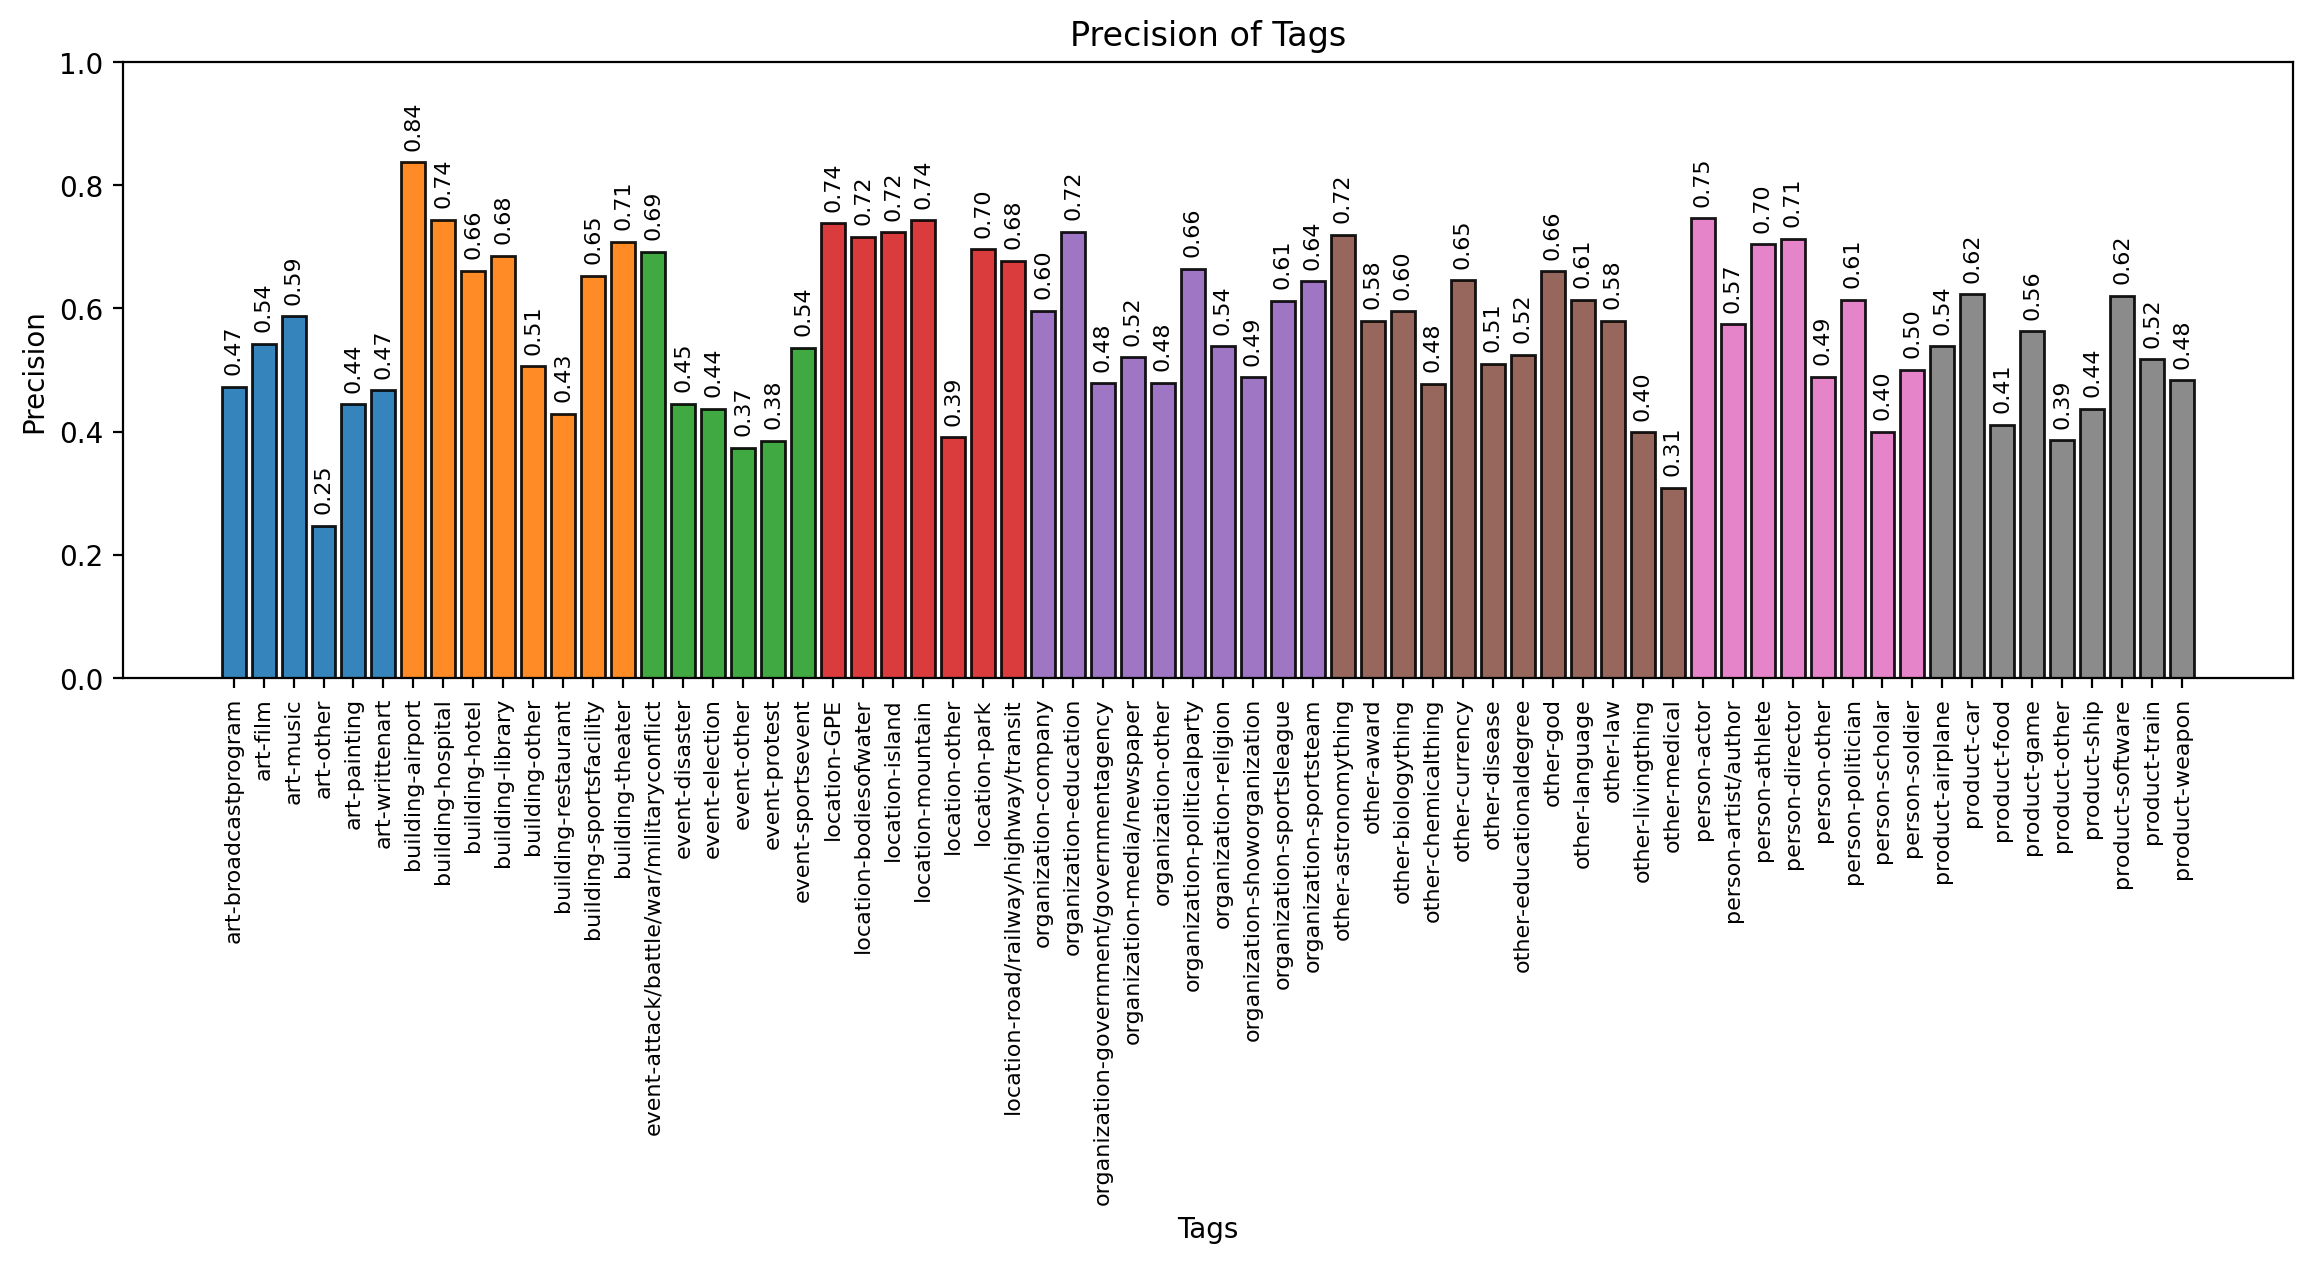

In [13]:
plot_classification_report(
    tag_names=list(TAG2IDX.keys())[2:],
    tag_scores=precision_score(y_true=batch_trues, y_pred=batch_preds, average=None)
)

# Demo

In [50]:
def predict_ner_for_sentence(
    sentence: str, 
    word2idx: Dict[str, int] = WORD2IDX,
    idx2word: Dict[int, str] = IDX2WORD,
    char2idx: Dict[str, int] = CHAR2IDX,
    max_seq_len: int = config.MAX_SEQ_LEN,
    max_word_len: int = config.MAX_WORD_LEN,
) -> List[str]:

    word_ids = [word2idx[token] if token in word2idx else word2idx['UKN'] for token in sentence.split(' ')]
    word_ids = padding(word_ids, max_len=max_seq_len)
    
    char_ids = []
    for word_id in word_ids:
        word = idx2word[word_id] if word_id in idx2word else 'UNK'
        char_seq = [char2idx[ch] if ch in char2idx else char2idx['UKN'] for ch in word]
        char_seq = padding(char_seq, max_len=max_word_len)
        char_ids.append(char_seq)

    word_ids = torch.tensor(word_ids)
    char_ids = torch.tensor(char_ids)
    mask = (word_ids > 0).bool()

    emission_scores = model(word_ids=word_ids.unsqueeze(0), char_ids=char_ids.unsqueeze(0))
    preds = torch.tensor(model.decode(emission_scores)).squeeze()
    preds = [IDX2TAG[idx] for idx in preds[mask].tolist()]
    preds = io2bio(preds)

    return preds

In [51]:
# let's generate some seentencess using chatGPT
sentence = "The Mona Lisa is located in Paris and was painted by Leonardo da Vinci."
sentence = "In the Louvre museum, visitors admired the exquisite paintings of Vincent van Gogh while discussing the impact of his work on modern art."
sentence = "During a protest organized by Greta Thunberg, environmental activists gathered in front of the United Nations headquarters to demand urgent action on climate change."
sentence = "The Tokyo Olympics showcased the prowess of athletes from around the globe, bringing together nations in the spirit of friendly competition and sportsmanship."
sentence = "At the Nobel Prize ceremony, the renowned physicist Stephen Hawking received recognition for his groundbreaking contributions to theoretical physics, and the event was attended by leaders from the European Organization for Nuclear Research (CERN) and influential figures from the global scientific community."

In [52]:
highlighted_text = highlight_entities(
    tokens=sentence.split(' '), 
    ner_tags=predict_ner_for_sentence(sentence=sentence), 
    font_size=20
)
HTML(highlighted_text)

In [17]:
# version 45
# !tensorboard --logdir=artefacts/fine_grained/runs